# First implementation of a GNN (GCN)
In this notebook, we build the graph from an initial dataframe, and we execute the first implementation of our GNN, which contains 1 convolutive layer and 1 fully-connected layer.

## Notebook plan : 
1. Building the graph
2. Building the GCN

In [1]:
import pandas as pd
import numpy as np
from models.BuildGraph import BuildGraph

## 1. Building the graph
Here, we split the patients by tumour type. We merge tumour types if they contain only 1 patient.

### Reading the dataset

In [2]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


In [3]:
buildgraph = BuildGraph(df)

### Compute the adjacency matrix

In [4]:
buildgraph.compute_adjacency_matrix("Tumour type")
display(buildgraph.A)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Build the graph

In [5]:
features_label = ["CD8+ T cell score","Exome mut per mb"]
y_label = ["Clinical benefit"]

buildgraph.create_graph(features_label, y_label)

### Show the graph

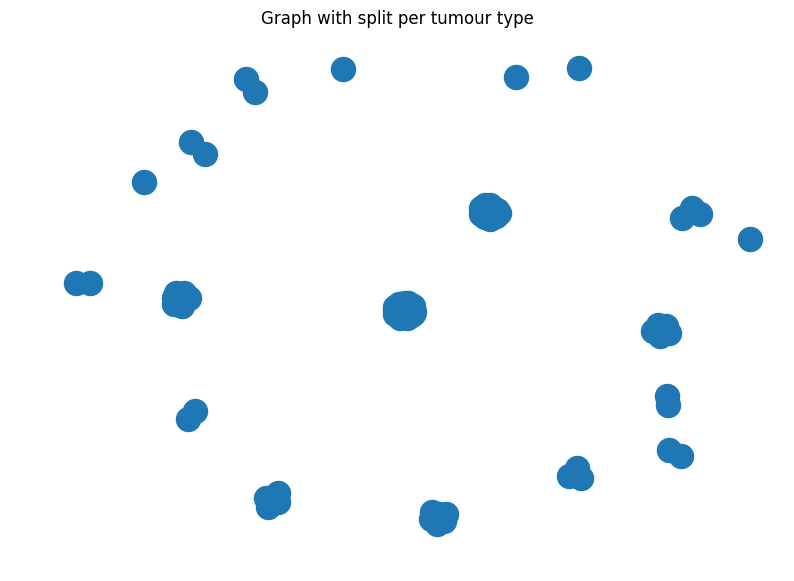

In [6]:
buildgraph.show_graph("Graph with split per tumour type","tumour-type.png")

## 2. Building the GCN

### Formatting data

In [ ]:
import torch
x = torch.rand(2, 2, 5, 3)
print(x)

tensor([[[[0.9233, 0.2057, 0.2704],
          [0.5437, 0.8418, 0.4488],
          [0.3578, 0.4455, 0.1678],
          [0.4189, 0.2319, 0.8284],
          [0.8293, 0.8863, 0.0125]],

         [[0.2591, 0.2626, 0.8671],
          [0.0211, 0.6352, 0.8176],
          [0.7242, 0.7078, 0.5726],
          [0.3382, 0.8159, 0.2419],
          [0.1908, 0.8088, 0.0832]]],


        [[[0.0884, 0.6098, 0.6256],
          [0.0903, 0.6613, 0.8076],
          [0.2723, 0.7662, 0.6548],
          [0.8481, 0.5062, 0.2261],
          [0.1469, 0.0163, 0.1051]],

         [[0.8890, 0.6551, 0.5036],
          [0.9328, 0.6075, 0.8558],
          [0.8007, 0.4049, 0.5326],
          [0.6983, 0.7300, 0.8832],
          [0.3239, 0.2466, 0.6543]]]])
